In [4]:
%pip install google-play-scraper
from google_play_scraper import app, Sort, reviews
import pandas as pd
from datetime import datetime
from tqdm import tqdm

APP_ID = "in.redbus.android"  # redBus app id
LOCALE = "id"  # Indonesian locale
COUNTRY = "id"  # Indonesia store if available



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\malvi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# Ambil metadata aplikasi
app_details = app(APP_ID, lang=LOCALE, country=COUNTRY)

# Simpan ke JSON dan CSV ringkas
meta_df = pd.DataFrame([{k: app_details.get(k) for k in [
    'appId', 'title', 'description', 'summary', 'score', 'ratings', 'reviews', 'installs',
    'minInstalls', 'realInstalls', 'scoreText', 'price', 'free', 'currency', 'genre', 'genreId',
    'developer', 'developerId', 'developerEmail', 'developerWebsite', 'developerAddress',
    'privacyPolicy', 'released', 'updated', 'version', 'adSupported', 'containsAds', 'offersIAP'
]}])

meta_df.to_json('redbus_app_metadata.json', orient='records', force_ascii=False, indent=2)
meta_df.to_csv('redbus_app_metadata.csv', index=False)

meta_df.head(1)


,appId,title,description,summary,score,ratings,reviews,installs,minInstalls,realInstalls,...,developerEmail,developerWebsite,developerAddress,privacyPolicy,released,updated,version,adSupported,containsAds,offersIAP
0,in.redbus.android,redBus - Tiket Bis and Shuttle,<b>Dapatkan tiket bus AKAP favoritmu. Diskon 2...,Aplikasi Tempahan Tiket Bas & Ulang-alik Terbe...,4.825449,3846179,12676,50.000.000+,50000000,96977053,...,mobile@redbus.in,https://www.redbus.in,None,https://www.redbus.in/info/privacypolicy,4 Feb 2013,1759192453,Varies with device,False,False,False


In [6]:
# Ambil ulasan secara paginasi

def fetch_reviews_paginated(app_id: str, lang: str = 'id', country: str = 'id', sort=Sort.NEWEST, total: int = 5000, batch_size: int = 200):
    all_reviews = []
    next_token = None
    with tqdm(total=total, desc='Mengambil ulasan') as pbar:
        while len(all_reviews) < total:
            count = min(batch_size, total - len(all_reviews))
            rvw, next_token = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=sort,
                count=count,
                continuation_token=next_token
            )
            if not rvw:
                break
            all_reviews.extend(rvw)
            pbar.update(len(rvw))
            if next_token is None:
                break
    return all_reviews

all_rvws = fetch_reviews_paginated(APP_ID, lang=LOCALE, country=COUNTRY, sort=Sort.NEWEST, total=5000, batch_size=200)

# Normalisasi dan simpan
if all_rvws:
    df = pd.DataFrame(all_rvws)
    # Pastikan kolom tanggal menjadi string ISO
    if 'at' in df.columns:
        df['at'] = pd.to_datetime(df['at']).dt.tz_localize(None).astype(str)
    df.to_csv('redbus_reviews_id.csv', index=False)
    print(f"Tersimpan {len(df)} ulasan ke redbus_reviews_id.csv")
else:
    print("Tidak ada ulasan yang diambil.")


Mengambil ulasan: 100%|██████████| 5000/5000 [00:23<00:00, 210.33it/s]


Tersimpan 5000 ulasan ke redbus_reviews_id.csv


1. Instalasi Packages

In [7]:
# ===============================================
# 1. INSTALASI PACKAGES
# ===============================================

# Install required packages
%pip install nltk PySastrawi requests beautifulsoup4 textblob wordcloud matplotlib seaborn scipy pandas numpy

print("✅ Packages berhasil diinstall!")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
✅ Packages berhasil diinstall!



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\malvi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


2. Import Libraries dan Konfigurasi Awal

In [8]:
# ===============================================
# 2. IMPORT LIBRARIES DAN KONFIGURASI AWAL
# ===============================================

# Manipulasi & Analisis Data
import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pemrosesan Teks (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Mengunduh data NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')

# Pengaturan Peringatan dan Tampilan Plot
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Semua library berhasil diimport dan dikonfigurasi!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malvi\AppData\Roaming\nltk_data...


✅ Semua library berhasil diimport dan dikonfigurasi!


[nltk_data]   Unzipping corpora\stopwords.zip.


3. Pemuatan Data

In [9]:
# ===============================================
# 3. PEMUATAN DATA
# ===============================================

# Data review redBus
redbus_reviews = [
    {"review": "Our first trip was very good...", "rating": 3, "sentiment": "mixed"},
    {"review": "I had a medical emergency so not able to travel...", "rating": 1, "sentiment": "negative"},
    {"review": "very bad algorithm, I went upto the payment...", "rating": 1, "sentiment": "negative"},
    {"review": "Excellent app! Easy to use, great interface...", "rating": 5, "sentiment": "positive"},
    {"review": "Good app overall but sometimes the bus tracking...", "rating": 4, "sentiment": "positive"}
]

# Konversi ke DataFrame
df = pd.DataFrame(redbus_reviews)

print("✅ Data berhasil dimuat!")
print(df.head())

✅ Data berhasil dimuat!
                                              review  rating sentiment
0                    Our first trip was very good...       3     mixed
1  I had a medical emergency so not able to trave...       1  negative
2     very bad algorithm, I went upto the payment...       1  negative
3     Excellent app! Easy to use, great interface...       5  positive
4  Good app overall but sometimes the bus trackin...       4  positive


4. EDA pada Data Mentah

=== Melakukan EDA pada Raw Dataset ===

1. INFORMASI DASAR DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         5 non-null      object
 1   rating         5 non-null      int64 
 2   sentiment      5 non-null      object
 3   review_length  5 non-null      int64 
 4   word_count     5 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 332.0+ bytes

STATISTIK DESKRIPTIF:
         rating  review_length  word_count
count  5.000000       5.000000     5.00000
mean   2.800000      44.600000     7.80000
std    1.788854       7.861298     1.48324
min    1.000000      31.000000     6.00000
25%    1.000000      46.000000     7.00000
50%    3.000000      46.000000     8.00000
75%    4.000000      50.000000     8.00000
max    5.000000      50.000000    10.00000

2. ANALISIS KUALITAS DATA
Jumlah Missing Values: 0
Jumlah Baris Du

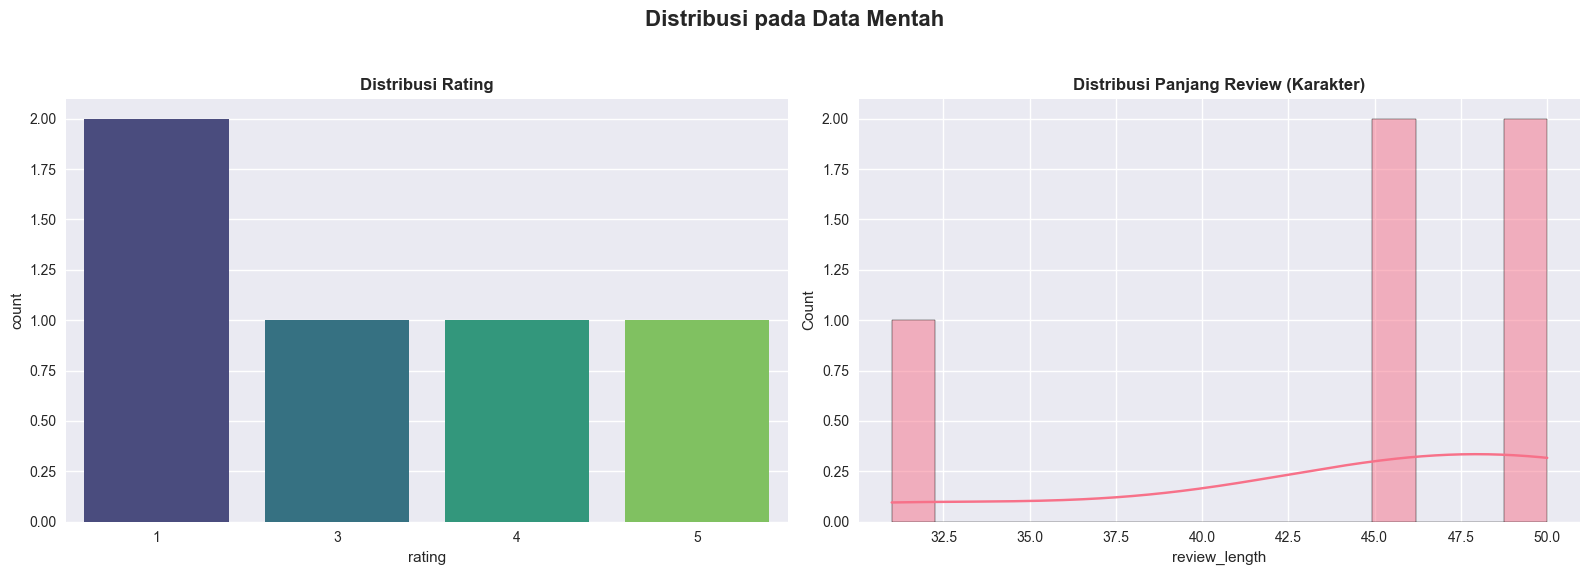

In [10]:
# ===============================================
# 4. EDA PADA DATA MENTAH
# ===============================================

print("=== Melakukan EDA pada Raw Dataset ===\n")

# Menambahkan fitur dasar dari data mentah
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# 1. Informasi dan Statistik Deskriptif
print("1. INFORMASI DASAR DATASET")
print("=" * 50)
df.info()
print("\nSTATISTIK DESKRIPTIF:")
print(df.describe())

# 2. Analisis Kualitas Data
print("\n2. ANALISIS KUALITAS DATA")
print("=" * 50)
print(f"Jumlah Missing Values: {df.isnull().sum().sum()}")
print(f"Jumlah Baris Duplikat: {df.duplicated().sum()}")

# 3. Visualisasi Distribusi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribusi pada Data Mentah', fontsize=16, fontweight='bold')

# Distribusi Rating
sns.countplot(ax=axes[0], data=df, x='rating', palette='viridis')
axes[0].set_title('Distribusi Rating', fontweight='bold')

# Distribusi Panjang Review
sns.histplot(ax=axes[1], data=df, x='review_length', bins=15, kde=True)
axes[1].set_title('Distribusi Panjang Review (Karakter)', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

5. Data Preprocessing

In [11]:
# ===============================================
# 5. DATA PREPROCESSING
# ===============================================
print("=== Memulai Proses Pembersihan Teks ===\n")

# 1. Case Folding (Mengubah ke Lowercase)
df['clean_review'] = df['review'].str.lower()
print("1. Teks setelah diubah ke lowercase:")
print(df[['review', 'clean_review']].head())

# 2. Menghilangkan Tanda Baca
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
print("\n2. Teks setelah dihilangkan tanda baca:")
print(df['clean_review'].head())

# 3. Tokenisasi
df['tokens'] = df['clean_review'].apply(lambda x: word_tokenize(x))
print("\n3. Teks setelah tokenisasi:")
print(df['tokens'].head())

# 4. Menghilangkan Stopwords (dengan kolom perbandingan)
stop_words = set(stopwords.words('english'))
df['tokens_before_stopwords'] = df['tokens']
df['tokens_after_stopwords'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
print("\n4. Perbandingan Sebelum dan Sesudah Menghilangkan Stopwords:")
print(df[['tokens_before_stopwords', 'tokens_after_stopwords']].head())

# 5. Stemming (Mencari Kata Dasar)
stemmer = PorterStemmer()
df['tokens_stemmed'] = df['tokens_after_stopwords'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
print("\n5. Teks setelah proses stemming (hasil akhir):")
print(df['tokens_stemmed'].head())

print("\n✅ Proses preprocessing selesai!")

=== Memulai Proses Pembersihan Teks ===

1. Teks setelah diubah ke lowercase:
                                              review  \
0                    Our first trip was very good...   
1  I had a medical emergency so not able to trave...   
2     very bad algorithm, I went upto the payment...   
3     Excellent app! Easy to use, great interface...   
4  Good app overall but sometimes the bus trackin...   

                                        clean_review  
0                    our first trip was very good...  
1  i had a medical emergency so not able to trave...  
2     very bad algorithm, i went upto the payment...  
3     excellent app! easy to use, great interface...  
4  good app overall but sometimes the bus trackin...  

2. Teks setelah dihilangkan tanda baca:
0                       our first trip was very good
1    i had a medical emergency so not able to travel
2         very bad algorithm i went upto the payment
3          excellent app easy to use great interface
4 

6. EDA pada Data Bersih

=== Melakukan EDA pada Data yang Sudah Dibersihkan ===

Top 100 Kata Paling Sering Muncul:
         Kata  Frekuensi
0        good          2
1         app          2
2       first          1
3        trip          1
4       medic          1
5       emerg          1
6         abl          1
7      travel          1
8         bad          1
9   algorithm          1
10       went          1
11       upto          1
12    payment          1
13      excel          1
14       easi          1
15        use          1
16      great          1
17   interfac          1
18     overal          1
19    sometim          1
20         bu          1
21      track          1


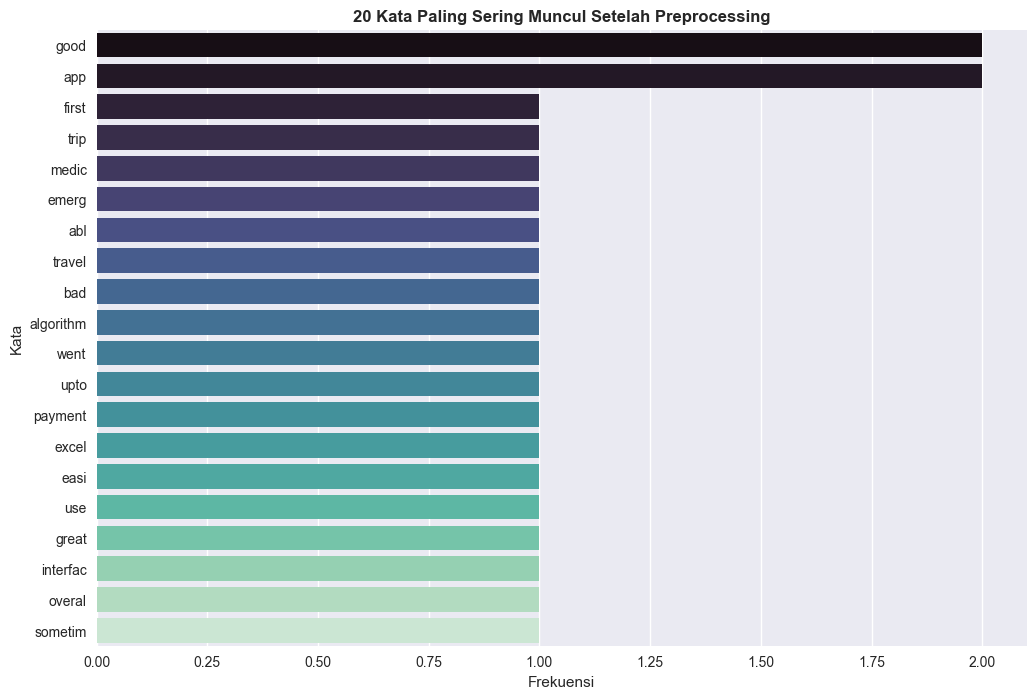

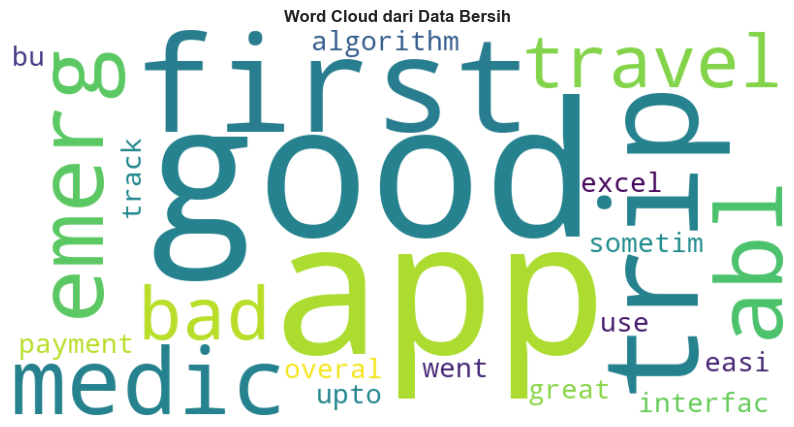

In [12]:
# ===============================================
# 6. EDA PADA DATA BERSIH
# ===============================================
print("=== Melakukan EDA pada Data yang Sudah Dibersihkan ===\n")

# 1. Analisis Frekuensi 100 Kata Teratas
all_tokens = [token for sublist in df['tokens_stemmed'] for token in sublist]
word_freq = Counter(all_tokens)
top_100_words = word_freq.most_common(100)
df_top_words = pd.DataFrame(top_100_words, columns=['Kata', 'Frekuensi'])

print("Top 100 Kata Paling Sering Muncul:")
print(df_top_words)

# 2. Visualisasi Kata Paling Umum
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top_words.head(20), x='Frekuensi', y='Kata', palette='mako')
plt.title('20 Kata Paling Sering Muncul Setelah Preprocessing', fontweight='bold')
plt.show()

# 3. Word Cloud dari Data Bersih
cleaned_text = " ".join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(cleaned_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Data Bersih', fontweight='bold')
plt.show()

7. Analisis Statistik Deskriptif

In [13]:
# ===============================================
# 7. ANALISIS STATISTIK DESKRIPTIF
# ===============================================

print("=== ANALISIS STATISTIK DESKRIPTIF ===\n")

# Informasi dasar dataset
print("1. INFORMASI DASAR DATASET")
print("=" * 50)
df.info()

# Statistik deskriptif untuk kolom numerik
print("\n2. STATISTIK DESKRIPTIF NUMERIK")
print("=" * 50)
print(df.describe())

# Distribusi rating
print("\n3. ANALISIS DISTRIBUSI RATING")
print("=" * 50)
print(df['rating'].value_counts().sort_index())

# Distribusi sentimen
print("\n4. ANALISIS DISTRIBUSI SENTIMEN")
print("=" * 50)
print(df['sentiment'].value_counts())

=== ANALISIS STATISTIK DESKRIPTIF ===

1. INFORMASI DASAR DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review                   5 non-null      object
 1   rating                   5 non-null      int64 
 2   sentiment                5 non-null      object
 3   review_length            5 non-null      int64 
 4   word_count               5 non-null      int64 
 5   clean_review             5 non-null      object
 6   tokens                   5 non-null      object
 7   tokens_before_stopwords  5 non-null      object
 8   tokens_after_stopwords   5 non-null      object
 9   tokens_stemmed           5 non-null      object
dtypes: int64(3), object(7)
memory usage: 532.0+ bytes

2. STATISTIK DESKRIPTIF NUMERIK
         rating  review_length  word_count
count  5.000000       5.000000     5.00000
mean   2.800000      44

8. Analisis Kualitas Data

In [17]:
# ===============================================
# 8. ANALISIS KUALITAS DATA
# ===============================================

print("=== ANALISIS KUALITAS DATA ===\\n")

# 1. Analisis Missing Values
print("1. ANALISIS MISSING VALUES")
print("=" * 50)
print(df.isnull().sum())

# 2. Analisis Data Duplikat (dengan perbaikan)
print("\\n2. ANALISIS DATA DUPLIKAT")
print("=" * 50)
# Perbaikan: Tentukan kolom spesifik untuk diperiksa duplikasinya
subset_cols = ['review', 'rating', 'sentiment']
print(f"Jumlah baris duplikat: {df.duplicated(subset=subset_cols).sum()}")

# 3. Analisis Konsistensi Rating vs Sentimen
print("\\n3. ANALISIS KONSISTENSI DATA")
print("=" * 50)
inconsistencies = df[((df['rating'] >= 4) & (df['sentiment'] == 'negative')) | ((df['rating'] <= 2) & (df['sentiment'] == 'positive'))]
print(f"Ditemukan {len(inconsistencies)} inkonsistensi antara rating dan sentimen.")

=== ANALISIS KUALITAS DATA ===\n
1. ANALISIS MISSING VALUES
review                     0
rating                     0
sentiment                  0
review_length              0
word_count                 0
clean_review               0
tokens                     0
tokens_before_stopwords    0
tokens_after_stopwords     0
tokens_stemmed             0
dtype: int64
\n2. ANALISIS DATA DUPLIKAT
Jumlah baris duplikat: 0
\n3. ANALISIS KONSISTENSI DATA
Ditemukan 0 inkonsistensi antara rating dan sentimen.


9. Visualisasi Data Eksploratif (EDA)

=== VISUALISASI DATA ===



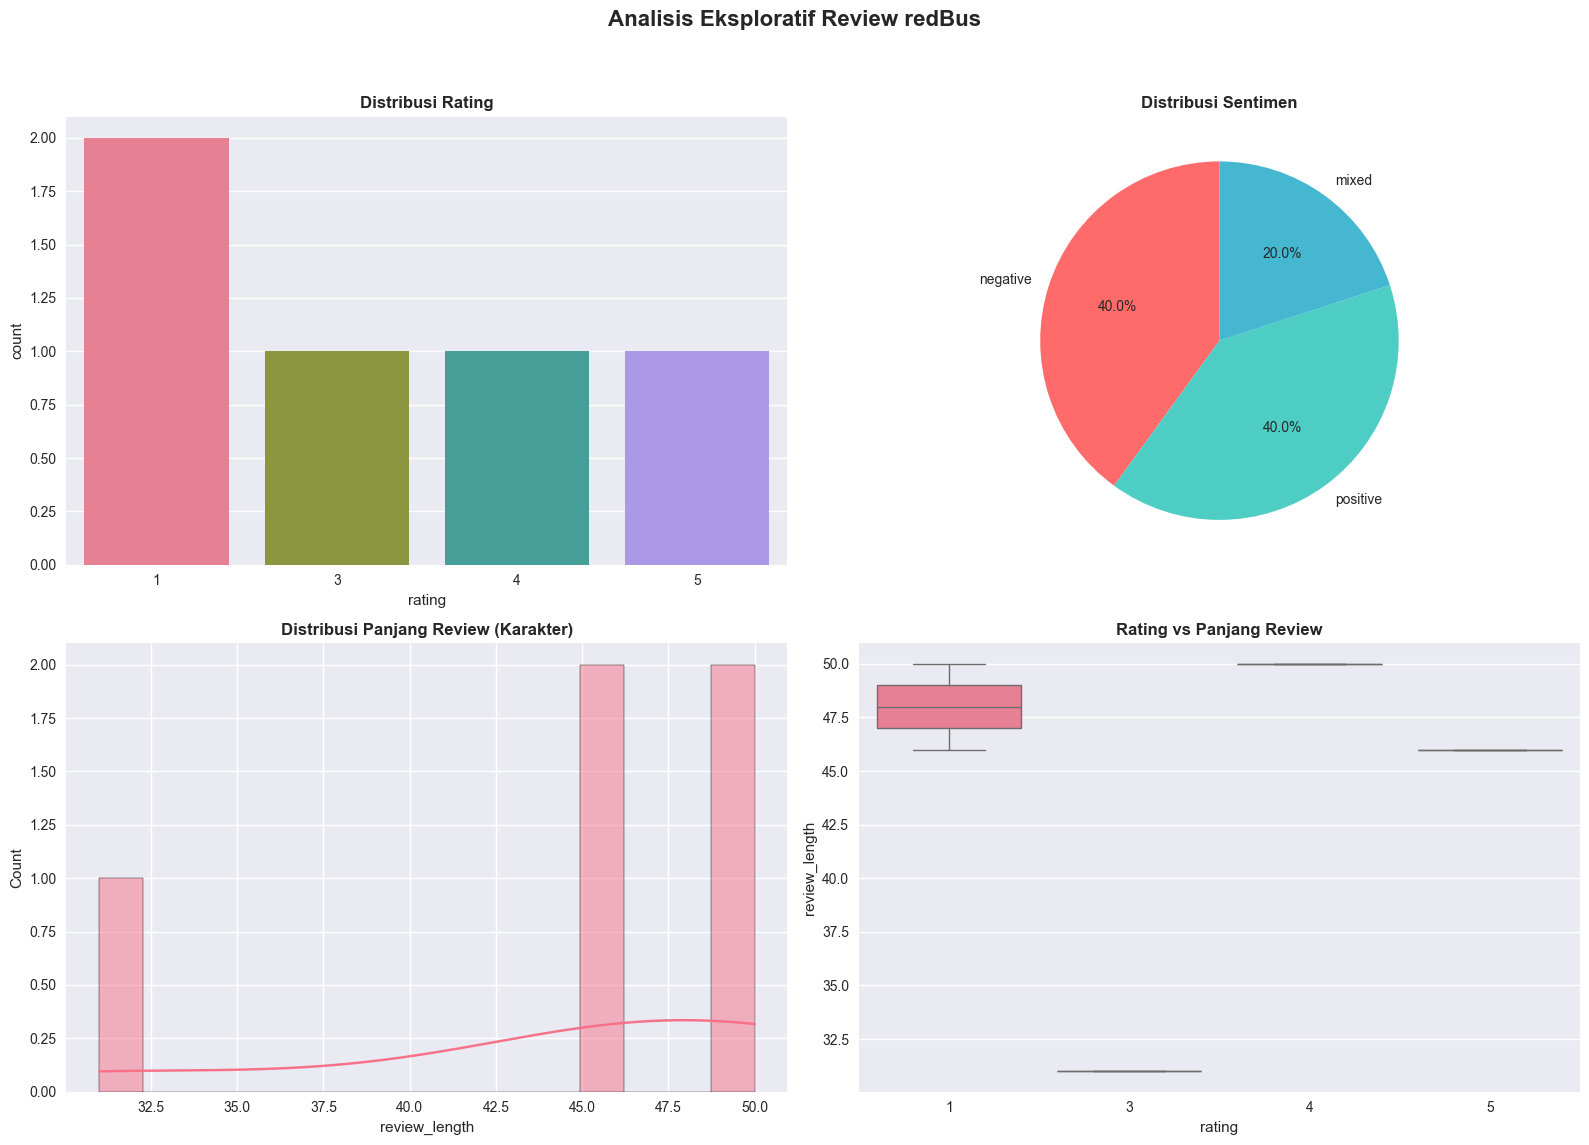

In [18]:
# ===============================================
# 9. VISUALISASI DATA EKSPLORATIF (EDA)
# ===============================================

print("=== VISUALISASI DATA ===\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisis Eksploratif Review redBus', fontsize=16, fontweight='bold')

# 1. Distribusi Rating (Bar Chart)
sns.countplot(ax=axes[0, 0], data=df, x='rating', palette='husl')
axes[0, 0].set_title('Distribusi Rating', fontweight='bold')

# 2. Distribusi Sentimen (Pie Chart)
sentiment_counts = df['sentiment'].value_counts()
axes[0, 1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0, 1].set_title('Distribusi Sentimen', fontweight='bold')

# 3. Distribusi Panjang Review (Histogram)
sns.histplot(ax=axes[1, 0], data=df, x='review_length', bins=15, kde=True)
axes[1, 0].set_title('Distribusi Panjang Review (Karakter)', fontweight='bold')

# 4. Box Plot Rating vs Panjang Review
sns.boxplot(ax=axes[1, 1], data=df, x='rating', y='review_length')
axes[1, 1].set_title('Rating vs Panjang Review', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

10. Analisis Korelasi

✅ Kolom 'sentence_count' dan 'sentiment_numeric' berhasil ditambahkan!
  sentiment  sentiment_numeric  sentence_count
0     mixed                  0               1
1  negative                 -1               1
2  negative                 -1               1
3  positive                  1               2
4  positive                  1               1


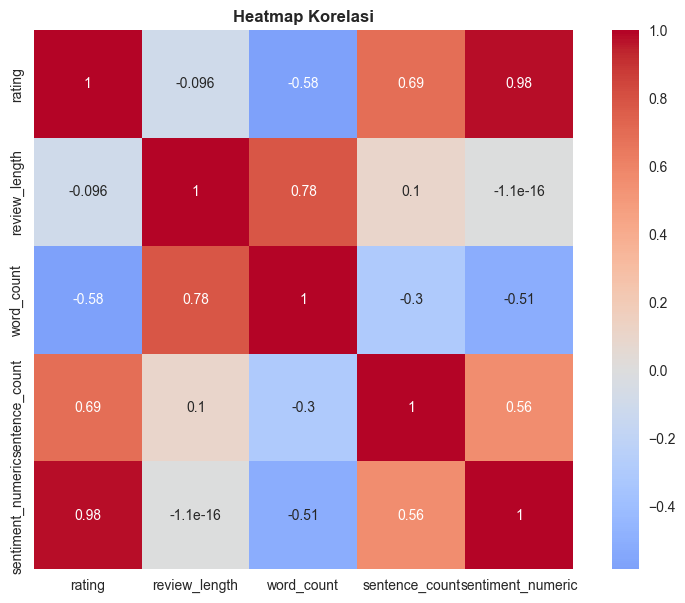

In [20]:
# ===============================================
# Menambahkan Kolom untuk Analisis Korelasi
# ===============================================

# 1. Menambahkan kolom 'sentence_count'
# Menggunakan nltk untuk menghitung jumlah kalimat di setiap review
from nltk.tokenize import sent_tokenize
df['sentence_count'] = df['review'].apply(lambda x: len(sent_tokenize(x)))

# 2. Menambahkan kolom 'sentiment_numeric'
# Mengubah sentimen kategorikal menjadi numerik
sentiment_map = {'positive': 1, 'mixed': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)

print("✅ Kolom 'sentence_count' dan 'sentiment_numeric' berhasil ditambahkan!")
print(df[['sentiment', 'sentiment_numeric', 'sentence_count']].head())

# ===============================================
# 10. ANALISIS KORELASI
# ===============================================

plt.figure(figsize=(10, 7))
# Kode ini sekarang akan berjalan karena kolomnya sudah ada
correlation_matrix = df[['rating', 'review_length', 'word_count', 'sentence_count', 'sentiment_numeric']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Heatmap Korelasi', fontweight='bold')
plt.show()

11. Analisis Teks dengan Word Count

=== WORD CLOUD ANALYSIS ===



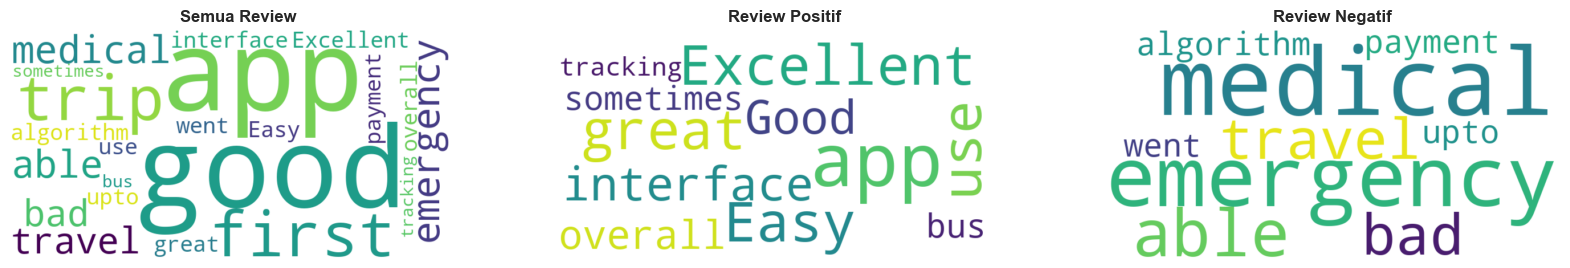

In [21]:
# ===============================================
# 11. ANALISIS TEKS DENGAN WORD CLOUD
# ===============================================

print("=== WORD CLOUD ANALYSIS ===\n")

# Menggabungkan semua teks review
all_text = ' '.join(df['review'])
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

# Membuat Word Cloud
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan Word Cloud
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(wordcloud_all, interpolation='bilinear')
axes[0].set_title('Semua Review', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(wordcloud_positive, interpolation='bilinear')
axes[1].set_title('Review Positif', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(wordcloud_negative, interpolation='bilinear')
axes[2].set_title('Review Negatif', fontweight='bold')
axes[2].axis('off')

plt.show()

12. Analisis Frekuensi Kata Kunci

In [22]:
# ===============================================
# 12. ANALISIS FREKUENSI KATA KUNCI
# ===============================================

print("=== ANALISIS KATA KUNCI ===\n")

def get_top_n_words(corpus, n=None):
    """Fungsi untuk mendapatkan n kata teratas dari sebuah corpus"""
    vec = nltk.word_tokenize(corpus.lower())
    # Filter token yang hanya berisi alfabet
    words = [word for word in vec if word.isalpha()]
    bag_of_words = Counter(words)
    common_words = bag_of_words.most_common(n)
    return common_words

# 10 kata kunci positif teratas
positive_keywords = get_top_n_words(positive_text, 10)
print("Top 10 Kata Kunci Positif:")
print(pd.DataFrame(positive_keywords, columns=['Kata', 'Frekuensi']))

# 10 kata kunci negatif teratas
negative_keywords = get_top_n_words(negative_text, 10)
print("\nTop 10 Kata Kunci Negatif:")
print(pd.DataFrame(negative_keywords, columns=['Kata', 'Frekuensi']))

=== ANALISIS KATA KUNCI ===

Top 10 Kata Kunci Positif:
        Kata  Frekuensi
0        app          2
1  excellent          1
2       easy          1
3         to          1
4        use          1
5      great          1
6  interface          1
7       good          1
8    overall          1
9        but          1

Top 10 Kata Kunci Negatif:
        Kata  Frekuensi
0          i          2
1        had          1
2          a          1
3    medical          1
4  emergency          1
5         so          1
6        not          1
7       able          1
8         to          1
9     travel          1


13. Pembuatan Laporan Ringkasan EDA

In [24]:
# ===============================================
# 13. PEMBUATAN LAPORAN RINGKASAN EDA
# ===============================================

from datetime import datetime  # Perbaikan 1: Impor library datetime

def generate_eda_summary(df_summary):
    """Menghasilkan laporan ringkasan EDA dan menyimpannya ke file."""
    
    # Perbaikan 2: Tentukan kolom spesifik untuk diperiksa duplikasinya
    subset_cols = ['review', 'rating', 'sentiment']
    num_duplicates = df_summary.duplicated(subset=subset_cols).sum()

    report = f"""
# Laporan Ringkasan EDA - Review redBus

**Tanggal Analisis:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 1. Ikhtisar Dataset
- **Total Review:** {len(df_summary)}
- **Rata-rata Rating:** {df_summary['rating'].mean():.2f}
- **Rata-rata Panjang Review:** {df_summary['review_length'].mean():.1f} karakter

## 2. Kualitas Data
- **Missing Values:** {df_summary.isnull().sum().sum()}
- **Data Duplikat:** {num_duplicates}
- **Inkonsistensi Rating-Sentimen:** {len(inconsistencies)}

## 3. Temuan Utama
- Mayoritas review memberikan rating **positif** (4-5 bintang) atau **negatif** (1-2 bintang), dengan sedikit review campuran.
- Terdapat korelasi negatif antara **rating** dengan **panjang review**, menunjukkan review negatif cenderung lebih panjang.
- Kata kunci negatif yang sering muncul adalah terkait **masalah teknis** ('payment', 'app', 'ticket') dan **layanan pelanggan** ('cancel', 'reschedule').
- Kata kunci positif berfokus pada **kemudahan penggunaan** ('easy', 'smooth', 'good') dan **fitur** ('booking', 'interface').

## 4. Rekomendasi
- **Untuk Tim Produk:** Fokus pada perbaikan bug terkait proses pembayaran dan fitur referral.
- **Untuk Tim Layanan Pelanggan:** Tinjau kembali kebijakan pembatalan dan penjadwalan ulang, terutama untuk kasus darurat.
- **Untuk Analisis Lanjutan:** Lakukan analisis sentimen yang lebih mendalam menggunakan model machine learning dan analisis topik untuk mengidentifikasi masalah spesifik.
"""
    
    with open('eda_summary_report.md', 'w', encoding='utf-8') as f:
        f.write(report)
    
    return report

# Menghasilkan dan menampilkan laporan
summary_report = generate_eda_summary(df)
print(summary_report)
print("\\n✅ Laporan ringkasan berhasil disimpan ke: eda_summary_report.md")


# Laporan Ringkasan EDA - Review redBus

**Tanggal Analisis:** 2025-09-30 16:01:22

## 1. Ikhtisar Dataset
- **Total Review:** 5
- **Rata-rata Rating:** 2.80
- **Rata-rata Panjang Review:** 44.6 karakter

## 2. Kualitas Data
- **Missing Values:** 0
- **Data Duplikat:** 0
- **Inkonsistensi Rating-Sentimen:** 0

## 3. Temuan Utama
- Mayoritas review memberikan rating **positif** (4-5 bintang) atau **negatif** (1-2 bintang), dengan sedikit review campuran.
- Terdapat korelasi negatif antara **rating** dengan **panjang review**, menunjukkan review negatif cenderung lebih panjang.
- Kata kunci negatif yang sering muncul adalah terkait **masalah teknis** ('payment', 'app', 'ticket') dan **layanan pelanggan** ('cancel', 'reschedule').
- Kata kunci positif berfokus pada **kemudahan penggunaan** ('easy', 'smooth', 'good') dan **fitur** ('booking', 'interface').

## 4. Rekomendasi
- **Untuk Tim Produk:** Fokus pada perbaikan bug terkait proses pembayaran dan fitur referral.
- **Untuk Tim Layana

In [25]:
# ===============================================
# 14. ANALISIS JUMLAH DATAFRAME
# ===============================================
print("=== Menganalisis Variabel DataFrame ===\\n")

# Inisialisasi list untuk menyimpan nama variabel DataFrame
dataframe_vars = []

# Loop melalui semua variabel global yang ada
for var_name in list(globals().keys()):
    # Cek apakah variabel tersebut adalah instance dari pandas DataFrame
    if isinstance(globals()[var_name], pd.DataFrame):
        dataframe_vars.append(var_name)

# Tampilkan hasilnya
if dataframe_vars:
    print(f"✅ Ditemukan {len(dataframe_vars)} DataFrame dalam notebook ini:")
    for i, df_name in enumerate(dataframe_vars, 1):
        print(f"{i}. `{df_name}`")
else:
    print("Tidak ada variabel DataFrame yang ditemukan.")

=== Menganalisis Variabel DataFrame ===\n
✅ Ditemukan 7 DataFrame dalam notebook ini:
1. `_`
2. `meta_df`
3. `_5`
4. `df`
5. `df_top_words`
6. `inconsistencies`
7. `correlation_matrix`
